In [1]:
# Import the required libraries
import torch
import torchvision.datasets as datasets
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
import torch.utils.data
from torchvision import transforms
from torchvision.utils import save_image
from torch.nn.functional import interpolate
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from PIL import Image

import math
import numpy as np
import pandas as pd

import os
from natsort import natsorted
import random
import pickle
from tqdm import tqdm

In [2]:
# Code to upload dataset to google colab
try:
    from google.colab import drive
    drive.mount('/content/drive')

    import zipfile

    path_to_zip_file = 'drive/MyDrive/data.zip'
    directory_to_extract_to = 'VISCHEMA_PLUS/'
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
        zip_ref.extractall(directory_to_extract_to)

    !cp "drive/MyDrive/viscplus_train.csv" "VISCHEMA_PLUS/"
    !cp "drive/MyDrive/viscplus_val.csv" "VISCHEMA_PLUS/"
except:
    print("not in colab")

not in colab


In [3]:
train_csv = pd.read_csv(f"VISCHEMA_PLUS/viscplus_train.csv", header = None)
print(len(train_csv))

print(len(train_csv[0:10]))
print(train_csv[0].values.tolist()[0:10])

1280
10
['sun_bqhdmnfpgbhtjemq.jpg', 'sun_brvopxqzbbmiggcc.jpg', 'sun_bykwtyvknquxsqzc.jpg', 'sun_bywhnbwhctljokav.jpg', 'sun_bcyqhmsuncrhyodx.jpg', 'sun_bglqunwuycxydmyu.jpg', 'sun_bjqxowluzxgdvssb.jpg', 'sun_brfossphjulspavp.jpg', 'sun_bmoouvnnsnxypsla.jpg', 'sun_brrpdracygynlgwk.jpg']


In [4]:
# Create datasets and dataloaders
class VISCHEMA_PLUS(Dataset):
    def __init__(self, dataset_dir = 'VISCHEMA_PLUS/', image_dir = 'images/', label_dir = 'vms/', train = True, transform = None, limit_length=False):
        
        if train:
            train_csv = pd.read_csv(f"{dataset_dir}viscplus_train.csv", header = None)
            if limit_length:
              all_images = train_csv[0].values.tolist()[0:10]
            else:
              all_images = train_csv[0].values.tolist()
        else:
            val_csv = pd.read_csv(f"{dataset_dir}viscplus_val.csv" , header = None)
            if limit_length:
              all_images = val_csv[0].values.tolist()[0:10]
            else:
              all_images = val_csv[0].values.tolist()
            
        self.transform = transform
        
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.dataset_dir = dataset_dir
        
        self.all_images = natsorted(all_images)
        
    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):    
        convert_tensor = transforms.ToTensor()
        
        image = Image.open(f"{self.dataset_dir}{self.image_dir}{self.all_images[idx]}").convert("RGB")
        image = convert_tensor(image)

        label = Image.open(f"{self.dataset_dir}{self.label_dir}{self.all_images[idx]}").convert("RGB")
        label = convert_tensor(label)
        
        if self.transform != None:
            image = self.transform(image)
            label = self.transform(label)
            
        return image, label

batch_size = 1
limit_length = 0
image_size = 64

image_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.Normalize(0.5,0.5)
])

train_dataset = VISCHEMA_PLUS(transform = image_transforms, train=True, limit_length=limit_length)
val_dataset   = VISCHEMA_PLUS(transform = image_transforms, train=False, limit_length=limit_length)

train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True)
val_loader   = DataLoader(dataset = val_dataset,   batch_size = batch_size, shuffle=True)

print(f'{len(train_dataset)} Items in Train dataset')
print(f'{len(val_dataset)}  Items in Validation dataset')

1280 Items in Train dataset
320  Items in Validation dataset


c:\Users\bluep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


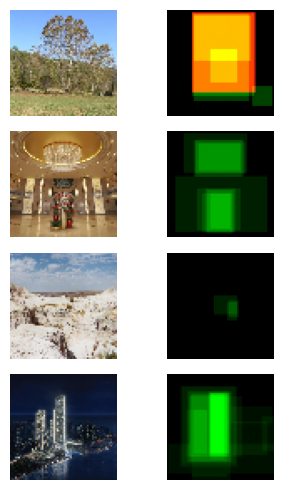

In [5]:
# Examine some image label pairs
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(5,5))
cols, rows = 3, 4
for i in range(rows):
    
    images, labels = next(iter(train_loader))
    
    # The image
    figure.add_subplot(rows,cols, cols*i+1)
    plt.axis("off")
    plt.imshow((images[0].squeeze().permute(1, 2, 0) +1 )/2 )
    
    # The Label
    figure.add_subplot(rows,cols, cols*i+2)
    plt.axis("off")
    plt.imshow((labels[0].squeeze().permute(1, 2, 0) +1 )/2)
    
plt.tight_layout()
plt.show()

In [6]:
class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=32, scheduler="cosine"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        if scheduler == "cosine":
            self.beta = self.prepare_cosine_schedule()
            self.beta = self.beta.type(torch.FloatTensor).to(self.device)
        else:
            self.beta = self.prepare_noise_schedule().to(self.device)

        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def prepare_cosine_schedule(self, s = 0.008):
        # This schedule function is by Chen, On the Importance of Noise Scheduling for Diffusion Models
        steps = self.noise_steps + 1
        t = torch.linspace(0, self.noise_steps, steps, dtype = torch.float64) / self.noise_steps
        alphas_cumprod = torch.cos((t + s) / (1 + s) * math.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return torch.clip(betas, 0, 0.999)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n):
        model.eval()
        with torch.no_grad():
            images, labels = next(iter(val_loader))
            images, labels = images[0:n].to(self.device), labels[0:n].to(self.device)
            x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
            
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(torch.cat((images,x),1), t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(images)
                else:
                    noise = torch.zeros_like(images)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return torch.cat([(images+1)/2, (labels+1)/2, x], dim=0)
    
    def test_across_validation(self, model, run_name):
        total_loss = 0
        loss_func  = nn.L1Loss()
        
        model.eval()
        with torch.no_grad():

            # Loop through every image in our validation set
            pbar = tqdm(val_loader)
            for i, (images, labels) in enumerate(pbar):
                
                # Create a batch of images, a batch of labels, and a batch of noise
                images, labels = images.to(self.device), labels.to(self.device)
                x = torch.randn((batch_size, 3, self.img_size, self.img_size)).to(self.device)

                # noise_steps amount of noise removal
                for j in tqdm(reversed(range(1, self.noise_steps)), position=0):
                    t = (torch.ones(batch_size) * j).long().to(self.device)

                    # Given the current state of noise and the timestep, what does the model think is the next state of noise
                    predicted_noise = model(torch.cat((images,x),1), t)
                    alpha = self.alpha[t][:, None, None, None]
                    alpha_hat = self.alpha_hat[t][:, None, None, None]
                    beta = self.beta[t][:, None, None, None]
                    if j > 1:
                        noise = torch.randn_like(images)
                    else:
                        noise = torch.zeros_like(images)

                    # Remove the noise that the model thinks is present from the noise
                    x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
                
                # Transform the output into an image
                x = (x.clamp(-1, 1) + 1) / 2
                x = (x * 255).type(torch.uint8)
                
                # Save images to disk
                save_images(torch.cat([(images+1)/2, (labels+1)/2, x], dim=0),f'saved_images/{run_name}',f"/{i}.png")

                # Compute the loss
                total_loss += loss_func(x, labels).item() * batch_size
        
        total_loss /= len(val_dataset)
        return total_loss

In [7]:
# UNET
class SelfAttention(nn.Module):
    def __init__(self, channels):
        super(SelfAttention, self).__init__()
        self.channels = channels        
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        size = x.shape[-1]
        x = x.view(-1, self.channels, size * size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, size, size)

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        try:
            x2 = self.maxpool_conv(x)
            emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x2.shape[-2], x2.shape[-1])
            return x2 + emb
        except:
            print(x.size())
            x = self.maxpool_conv(x)
            print(x.size())
            emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
            print(emb.size())
            return x + emb

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class UNet(nn.Module):
    def __init__(self, c_in=6, c_out=3, time_dim=256, remove_deep_conv=False):
        super().__init__()
        self.time_dim = time_dim
        self.remove_deep_conv = remove_deep_conv
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256)
        self.down3 = Down(256, 512)
        self.sa3 = SelfAttention(512)

        self.bot1 = DoubleConv(512, 1024)
        self.bot2 = DoubleConv(1024, 1024)
        self.bot3 = DoubleConv(1024, 512)

        self.up1 = Up(768, 256)
        self.sa4 = SelfAttention(256)
        self.up2 = Up(384, 128)
        self.sa5 = SelfAttention(128)
        self.up3 = Up(192, 64)
        self.sa6 = SelfAttention(64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device = device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def unet_forwad(self, x, t):
        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output
    
    def forward(self, x, t):
        t = t.unsqueeze(-1)
        t = self.pos_encoding(t, self.time_dim)
        return self.unet_forwad(x, t)

In [8]:
def save_images(images, path, image_name = ""):

    exists = os.path.exists(path)
    if not exists:
        os.makedirs(path)

    grid = torchvision.utils.make_grid(images, nrow = batch_size)
    save_image(grid, path+image_name)

In [9]:
def train(run_name, diffusion):
    # Saved images and model directories
    for path in [f"models/{run_name}", f"results/{run_name}", f"train_losses/{run_name}", f"val_losses/{run_name}"]:
        exists = os.path.exists(path)
        if not exists:
            os.makedirs(path)

    # Set up our training environment
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet().to(device)
    model.load_state_dict(torch.load(f"models/{run_name}/750.pt"))
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
    mse = nn.MSELoss()
    l = len(train_loader)

    train_losses = []
    val_losses = []

    num_epochs = 1000
    
    for epoch in range(750, num_epochs):
        total_train_loss = 0
        total_val_loss = 0
        print(f"Epoch: {epoch}")
        
        # Train Generator
        model.train()
        pbar = tqdm(train_loader)
        for i, (images, labels) in enumerate(pbar):
            images, labels = images.to(device), labels.to(device)    
            t = diffusion.sample_timesteps(labels.shape[0]).to(device)
            x_t, noise = diffusion.noise_images(labels, t)

            predicted_noise = model(torch.cat((images, x_t), 1), t)
            loss = mse(noise, predicted_noise)
            total_train_loss += loss.item() * batch_size

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * batch_size
            pbar.set_postfix(Train_Loss = total_train_loss)
            
            # Clear memory
            del images, labels, t, x_t, noise, predicted_noise
            torch.cuda.empty_cache() 

        # Validate Generator
        model.eval()
        with torch.no_grad():
            pbar = tqdm(val_loader)
            for i, (images, labels) in enumerate(pbar):

                images, labels = images.to(device), labels.to(device)
                
                t = diffusion.sample_timesteps(labels.shape[0]).to(device)
                x_t, noise = diffusion.noise_images(labels, t)

                predicted_noise = model(torch.cat((images, x_t), 1), t)
                loss = mse(noise, predicted_noise)
                total_val_loss += loss.item() * batch_size

                pbar.set_postfix(Val_loss = total_val_loss)

                del t, x_t, noise

        # Save losses
        train_losses.append(total_train_loss/ len(train_loader))
        val_losses.append(total_val_loss / len(val_loader))

        print(f"Epoch: {epoch} train: {train_losses[-1]} val: {val_losses[-1]}")

        # Save sample images every 20 epochs
        if epoch % 50 == 0:
            sampled_images = diffusion.sample(model, n=batch_size)
            print(sampled_images.size())
            save_images(sampled_images, f"results/{run_name}/", f"{epoch}.jpg")
            torch.save(model.state_dict(), f"models/{run_name}/{epoch}.pt")

        # Clear memory
        del images, labels
        torch.cuda.empty_cache()

    print(diffusion.test_across_validation(model, run_name))
    with open(os.path.join("train_losses",f"{run_name}.pkl"), 'wb') as f:
        pickle.dump(train_losses, f)
    with open(os.path.join("val_losses",f"{run_name}.pkl"), 'wb') as f:
        pickle.dump(val_losses, f)

In [10]:
# cosine_2000
run_name = "cosine2000"
diffusion = Diffusion(img_size = image_size, noise_steps=2000, scheduler="cosine")
train(run_name, diffusion)

Epoch: 750


100%|██████████| 320/320 [00:11<00:00, 27.41it/s, Val_loss=4.52]


Epoch: 750 train: 0.010443979951173788 val: 0.014136232376131375


1999it [00:38, 52.56it/s]


torch.Size([3, 3, 64, 64])
Epoch: 751


100%|██████████| 320/320 [00:11<00:00, 26.88it/s, Val_loss=3.48] 


Epoch: 751 train: 0.009314432450401 val: 0.010869372496654251
Epoch: 752


100%|██████████| 320/320 [00:11<00:00, 27.10it/s, Val_loss=3.83]


Epoch: 752 train: 0.011275160752120428 val: 0.011966342494952186
Epoch: 753


100%|██████████| 320/320 [00:11<00:00, 27.13it/s, Val_loss=3.73]


Epoch: 753 train: 0.008949136931755674 val: 0.011659206393460408
Epoch: 754


100%|██████████| 320/320 [00:11<00:00, 27.40it/s, Val_loss=3.61]


Epoch: 754 train: 0.009142108763182933 val: 0.01127786359570564
Epoch: 755


100%|██████████| 320/320 [00:12<00:00, 26.50it/s, Val_loss=4.04]


Epoch: 755 train: 0.009587688743226862 val: 0.012609970131461524
Epoch: 756


100%|██████████| 320/320 [00:10<00:00, 30.42it/s, Val_loss=3.85]


Epoch: 756 train: 0.010899882687385797 val: 0.01202211071763486
Epoch: 757


100%|██████████| 320/320 [00:10<00:00, 30.58it/s, Val_loss=3.49] 


Epoch: 757 train: 0.011098845030892335 val: 0.010915779623792332
Epoch: 758


100%|██████████| 320/320 [00:10<00:00, 30.62it/s, Val_loss=3.46] 


Epoch: 758 train: 0.01008997958033433 val: 0.010817505214117774
Epoch: 759


100%|██████████| 320/320 [00:10<00:00, 30.50it/s, Val_loss=3.91]


Epoch: 759 train: 0.010848702959492584 val: 0.012222505496902158
Epoch: 760


100%|██████████| 320/320 [00:10<00:00, 30.61it/s, Val_loss=3.41] 


Epoch: 760 train: 0.009650568882580045 val: 0.010665133942620742
Epoch: 761


100%|██████████| 320/320 [00:10<00:00, 30.48it/s, Val_loss=3.59] 


Epoch: 761 train: 0.01117793627449828 val: 0.011226524788708048
Epoch: 762


100%|██████████| 320/320 [00:10<00:00, 30.51it/s, Val_loss=3.44]


Epoch: 762 train: 0.009538058432622166 val: 0.010736311774326168
Epoch: 763


100%|██████████| 320/320 [00:10<00:00, 30.60it/s, Val_loss=3.5] 


Epoch: 763 train: 0.009642520778550078 val: 0.010940541655190827
Epoch: 764


100%|██████████| 320/320 [00:10<00:00, 30.46it/s, Val_loss=3.44]


Epoch: 764 train: 0.010072951098868544 val: 0.010761634380014585
Epoch: 765


100%|██████████| 320/320 [00:10<00:00, 30.63it/s, Val_loss=3.81] 


Epoch: 765 train: 0.009844931451652883 val: 0.011898303188309001
Epoch: 766


100%|██████████| 320/320 [00:10<00:00, 30.62it/s, Val_loss=3.87]


Epoch: 766 train: 0.009839296967925293 val: 0.012102443844514709
Epoch: 767


100%|██████████| 320/320 [00:10<00:00, 30.61it/s, Val_loss=3.12] 


Epoch: 767 train: 0.010385904946542724 val: 0.009750126950802952
Epoch: 768


100%|██████████| 320/320 [00:10<00:00, 30.61it/s, Val_loss=3.61] 


Epoch: 768 train: 0.010155404776833165 val: 0.01127163233813917
Epoch: 769


100%|██████████| 320/320 [00:10<00:00, 30.59it/s, Val_loss=3.97]


Epoch: 769 train: 0.010679027039088851 val: 0.012413729507125026
Epoch: 770


100%|██████████| 320/320 [00:10<00:00, 29.94it/s, Val_loss=3.42] 


Epoch: 770 train: 0.008816470062970438 val: 0.0106868275845045
Epoch: 771


100%|██████████| 320/320 [00:10<00:00, 30.59it/s, Val_loss=3.13] 


Epoch: 771 train: 0.009121986198942977 val: 0.009777233010481723
Epoch: 772


100%|██████████| 320/320 [00:10<00:00, 30.69it/s, Val_loss=3.65] 


Epoch: 772 train: 0.010036063028428544 val: 0.011409421701137035
Epoch: 773


100%|██████████| 320/320 [00:10<00:00, 30.50it/s, Val_loss=3.63]


Epoch: 773 train: 0.009163325545125644 val: 0.011351370962574946
Epoch: 774


100%|██████████| 320/320 [00:10<00:00, 30.34it/s, Val_loss=3.46] 


Epoch: 774 train: 0.009842258212688648 val: 0.01082449075356635
Epoch: 775


100%|██████████| 320/320 [00:10<00:00, 30.60it/s, Val_loss=4.76]


Epoch: 775 train: 0.00939729648409866 val: 0.014883008088872884
Epoch: 776


100%|██████████| 320/320 [00:10<00:00, 30.86it/s, Val_loss=3.52] 


Epoch: 776 train: 0.011434050239427052 val: 0.01101445409058215
Epoch: 777


100%|██████████| 320/320 [00:10<00:00, 30.75it/s, Val_loss=3.58] 


Epoch: 777 train: 0.008709915691088099 val: 0.011173489618909117
Epoch: 778


100%|██████████| 320/320 [00:10<00:00, 30.63it/s, Val_loss=3.73]


Epoch: 778 train: 0.011341419998939273 val: 0.01165740760961853
Epoch: 779


100%|██████████| 320/320 [00:10<00:00, 30.52it/s, Val_loss=3.97] 


Epoch: 779 train: 0.008246866737715663 val: 0.012412674840743421
Epoch: 780


100%|██████████| 320/320 [00:10<00:00, 30.53it/s, Val_loss=4.55]


Epoch: 780 train: 0.010483209005565186 val: 0.014207938817162358
Epoch: 781


100%|██████████| 320/320 [00:10<00:00, 30.45it/s, Val_loss=4.36] 


Epoch: 781 train: 0.009649242001739822 val: 0.01361314174605468
Epoch: 782


100%|██████████| 320/320 [00:10<00:00, 30.63it/s, Val_loss=3.84] 


Epoch: 782 train: 0.010464983814347305 val: 0.011999267445935402
Epoch: 783


100%|██████████| 320/320 [00:10<00:00, 30.49it/s, Val_loss=3.46]


Epoch: 783 train: 0.008832477017176644 val: 0.010815247373648163
Epoch: 784


100%|██████████| 320/320 [00:10<00:00, 30.54it/s, Val_loss=3.49]


Epoch: 784 train: 0.009882944528771986 val: 0.01092142835341292
Epoch: 785


100%|██████████| 320/320 [00:10<00:00, 30.61it/s, Val_loss=4.04]


Epoch: 785 train: 0.009842646268259614 val: 0.012628133211637759
Epoch: 786


100%|██████████| 320/320 [00:10<00:00, 30.67it/s, Val_loss=3.5] 


Epoch: 786 train: 0.00968987446428855 val: 0.01092209979206018
Epoch: 787


100%|██████████| 320/320 [00:10<00:00, 30.58it/s, Val_loss=3.96]


Epoch: 787 train: 0.009534397834204355 val: 0.012368873242030532
Epoch: 788


100%|██████████| 320/320 [00:10<00:00, 30.64it/s, Val_loss=3.03] 


Epoch: 788 train: 0.010755908841974814 val: 0.00946089123190177
Epoch: 789


100%|██████████| 320/320 [00:10<00:00, 30.70it/s, Val_loss=3.48] 


Epoch: 789 train: 0.010694374647960104 val: 0.010889757446420845
Epoch: 790


100%|██████████| 320/320 [00:10<00:00, 30.67it/s, Val_loss=3.91]


Epoch: 790 train: 0.00943965752649092 val: 0.012224647877474126
Epoch: 791


100%|██████████| 320/320 [00:10<00:00, 30.61it/s, Val_loss=3.93]


Epoch: 791 train: 0.010348884531981638 val: 0.01229327902683508
Epoch: 792


100%|██████████| 320/320 [00:10<00:00, 30.43it/s, Val_loss=3.68]


Epoch: 792 train: 0.009520704342537555 val: 0.011487942086341718
Epoch: 793


100%|██████████| 320/320 [00:10<00:00, 30.68it/s, Val_loss=3.66] 


Epoch: 793 train: 0.009937080233680718 val: 0.011450560803041299
Epoch: 794


100%|██████████| 320/320 [00:10<00:00, 30.65it/s, Val_loss=3.9]  


Epoch: 794 train: 0.011306130669959202 val: 0.012189680791880163
Epoch: 795


100%|██████████| 320/320 [00:10<00:00, 30.56it/s, Val_loss=3.95]


Epoch: 795 train: 0.009517300529205385 val: 0.012358199587197305
Epoch: 796


100%|██████████| 320/320 [00:10<00:00, 30.64it/s, Val_loss=3.37]


Epoch: 796 train: 0.010439999397272004 val: 0.01054573570067987
Epoch: 797


100%|██████████| 320/320 [00:10<00:00, 30.60it/s, Val_loss=3.91] 


Epoch: 797 train: 0.01091052681945257 val: 0.012205829021968383
Epoch: 798


100%|██████████| 320/320 [00:10<00:00, 30.47it/s, Val_loss=3.64]


Epoch: 798 train: 0.009488495270875318 val: 0.011362322462946394
Epoch: 799


100%|██████████| 320/320 [00:10<00:00, 30.51it/s, Val_loss=4.17]


Epoch: 799 train: 0.009265382348530693 val: 0.013030482274461973
Epoch: 800


100%|██████████| 320/320 [00:10<00:00, 30.59it/s, Val_loss=3.92] 


Epoch: 800 train: 0.010569784275776328 val: 0.012251757202011503


1999it [00:33, 60.35it/s]


torch.Size([3, 3, 64, 64])
Epoch: 801


100%|██████████| 320/320 [00:10<00:00, 30.56it/s, Val_loss=3.6] 


Epoch: 801 train: 0.008524056151622971 val: 0.011260395547174085
Epoch: 802


100%|██████████| 320/320 [00:10<00:00, 30.82it/s, Val_loss=3.7]  


Epoch: 802 train: 0.011469381296433313 val: 0.011550365828043141
Epoch: 803


100%|██████████| 320/320 [00:10<00:00, 30.63it/s, Val_loss=3.68] 


Epoch: 803 train: 0.010595023733731068 val: 0.011498823624697252
Epoch: 804


100%|██████████| 320/320 [00:10<00:00, 30.69it/s, Val_loss=3.69]


Epoch: 804 train: 0.009998024705350873 val: 0.011517662304413534
Epoch: 805


100%|██████████| 320/320 [00:10<00:00, 30.53it/s, Val_loss=3.53]


Epoch: 805 train: 0.010547232837461706 val: 0.011038749804174585
Epoch: 806


100%|██████████| 320/320 [00:10<00:00, 30.47it/s, Val_loss=4.03]


Epoch: 806 train: 0.008566175827581901 val: 0.012608886364319005
Epoch: 807


100%|██████████| 320/320 [00:10<00:00, 30.64it/s, Val_loss=3.46]


Epoch: 807 train: 0.00935467929658671 val: 0.01080089318120372
Epoch: 808


100%|██████████| 320/320 [00:10<00:00, 30.65it/s, Val_loss=3.68]


Epoch: 808 train: 0.009113943766124066 val: 0.011512713178035483
Epoch: 809


100%|██████████| 320/320 [00:10<00:00, 30.71it/s, Val_loss=3.95]


Epoch: 809 train: 0.009916526236679601 val: 0.012329961515933973
Epoch: 810


100%|██████████| 320/320 [00:10<00:00, 30.60it/s, Val_loss=3.5]  


Epoch: 810 train: 0.010270829170826801 val: 0.010935189516794707
Epoch: 811


100%|██████████| 320/320 [00:10<00:00, 30.70it/s, Val_loss=3.73]


Epoch: 811 train: 0.009093476710359028 val: 0.011663639750258881
Epoch: 812


100%|██████████| 320/320 [00:10<00:00, 30.50it/s, Val_loss=4.11] 


Epoch: 812 train: 0.010544516213826682 val: 0.012843176478713757
Epoch: 813


100%|██████████| 320/320 [00:10<00:00, 30.56it/s, Val_loss=4.22]


Epoch: 813 train: 0.009706325854983789 val: 0.013187567022214353
Epoch: 814


100%|██████████| 320/320 [00:10<00:00, 30.48it/s, Val_loss=4.32]


Epoch: 814 train: 0.009609217265824555 val: 0.013485690790230365
Epoch: 815


100%|██████████| 320/320 [00:10<00:00, 30.70it/s, Val_loss=3.89] 


Epoch: 815 train: 0.009138531566827623 val: 0.012152713282193871
Epoch: 816


100%|██████████| 320/320 [00:10<00:00, 30.47it/s, Val_loss=3.31]


Epoch: 816 train: 0.008615002489909785 val: 0.010358179209970331
Epoch: 817


100%|██████████| 320/320 [00:10<00:00, 30.58it/s, Val_loss=3.65]


Epoch: 817 train: 0.010918746009110691 val: 0.011420195174014224
Epoch: 818


100%|██████████| 320/320 [00:10<00:00, 30.59it/s, Val_loss=3.86]


Epoch: 818 train: 0.009727608571188285 val: 0.01205157990502812
Epoch: 819


100%|██████████| 320/320 [00:10<00:00, 30.58it/s, Val_loss=5.16] 


Epoch: 819 train: 0.01007978764090467 val: 0.01613979168823789
Epoch: 820


100%|██████████| 320/320 [00:10<00:00, 30.67it/s, Val_loss=3.71] 


Epoch: 820 train: 0.009973987156877228 val: 0.011601464615432633
Epoch: 821


100%|██████████| 320/320 [00:10<00:00, 30.64it/s, Val_loss=3.86] 


Epoch: 821 train: 0.009624743384870271 val: 0.01205214982956022
Epoch: 822


100%|██████████| 320/320 [00:10<00:00, 30.57it/s, Val_loss=3.74]


Epoch: 822 train: 0.008809512856691981 val: 0.011673783181731779
Epoch: 823


100%|██████████| 320/320 [00:10<00:00, 30.55it/s, Val_loss=3.77]


Epoch: 823 train: 0.008669468135951774 val: 0.011768776728831653
Epoch: 824


100%|██████████| 320/320 [00:10<00:00, 30.67it/s, Val_loss=3.67]


Epoch: 824 train: 0.009198209281726122 val: 0.011461686171105611
Epoch: 825


100%|██████████| 320/320 [00:10<00:00, 30.69it/s, Val_loss=3.4] 


Epoch: 825 train: 0.010069138135077083 val: 0.010632920488751552
Epoch: 826


100%|██████████| 320/320 [00:10<00:00, 30.58it/s, Val_loss=3.81] 


Epoch: 826 train: 0.010825315828446947 val: 0.01189448133359292
Epoch: 827


100%|██████████| 320/320 [00:10<00:00, 30.72it/s, Val_loss=3.98]


Epoch: 827 train: 0.008529479575042843 val: 0.012443233533622334
Epoch: 828


100%|██████████| 320/320 [00:10<00:00, 30.52it/s, Val_loss=3.83]


Epoch: 828 train: 0.009185823270354377 val: 0.011963462913809054
Epoch: 829


100%|██████████| 320/320 [00:10<00:00, 30.68it/s, Val_loss=3.37]


Epoch: 829 train: 0.009458853888600061 val: 0.010533289502745902
Epoch: 830


100%|██████████| 320/320 [00:10<00:00, 30.62it/s, Val_loss=3.76]


Epoch: 830 train: 0.008329072875903875 val: 0.011756138184591692
Epoch: 831


100%|██████████| 320/320 [00:10<00:00, 30.72it/s, Val_loss=3.23] 


Epoch: 831 train: 0.009682696510526511 val: 0.01010896761267759
Epoch: 832


100%|██████████| 320/320 [00:10<00:00, 30.71it/s, Val_loss=4.39] 


Epoch: 832 train: 0.009456017060688281 val: 0.013714639400859596
Epoch: 833


100%|██████████| 320/320 [00:10<00:00, 30.72it/s, Val_loss=3.94]


Epoch: 833 train: 0.009218315916132269 val: 0.012309700159948988
Epoch: 834


100%|██████████| 320/320 [00:10<00:00, 30.66it/s, Val_loss=3.71]


Epoch: 834 train: 0.0098014942583859 val: 0.011608625691906127
Epoch: 835


100%|██████████| 320/320 [00:10<00:00, 30.50it/s, Val_loss=4.38]


Epoch: 835 train: 0.00893400380903131 val: 0.013676061111800664
Epoch: 836


100%|██████████| 320/320 [00:10<00:00, 30.76it/s, Val_loss=3.59]


Epoch: 836 train: 0.010184857183025997 val: 0.011214227870596005
Epoch: 837


100%|██████████| 320/320 [00:10<00:00, 30.61it/s, Val_loss=4.29]


Epoch: 837 train: 0.00916469330967402 val: 0.013413185148692719
Epoch: 838


100%|██████████| 320/320 [00:10<00:00, 30.81it/s, Val_loss=3.6] 


Epoch: 838 train: 0.009621468368811748 val: 0.011250964540477072
Epoch: 839


100%|██████████| 320/320 [00:10<00:00, 30.68it/s, Val_loss=3.86]


Epoch: 839 train: 0.008721225020349267 val: 0.012048312063825506
Epoch: 840


100%|██████████| 320/320 [00:10<00:00, 30.60it/s, Val_loss=4.31]


Epoch: 840 train: 0.00819867968817789 val: 0.013464711913456995
Epoch: 841


100%|██████████| 320/320 [00:10<00:00, 30.19it/s, Val_loss=3.2]  


Epoch: 841 train: 0.008769621050942079 val: 0.010013268918919493
Epoch: 842


100%|██████████| 320/320 [00:10<00:00, 30.43it/s, Val_loss=3.88]


Epoch: 842 train: 0.009454045086022234 val: 0.01211286831171492
Epoch: 843


100%|██████████| 320/320 [00:10<00:00, 30.68it/s, Val_loss=3.52]


Epoch: 843 train: 0.009234490997732792 val: 0.01100720295944484
Epoch: 844


100%|██████████| 320/320 [00:10<00:00, 30.66it/s, Val_loss=3.42]


Epoch: 844 train: 0.009101118567900812 val: 0.010677997844413766
Epoch: 845


100%|██████████| 320/320 [00:10<00:00, 30.69it/s, Val_loss=3.57]


Epoch: 845 train: 0.008444101687882722 val: 0.01114751150084885
Epoch: 846


100%|██████████| 320/320 [00:10<00:00, 30.64it/s, Val_loss=3.38] 


Epoch: 846 train: 0.009112863965606266 val: 0.010557881636941602
Epoch: 847


100%|██████████| 320/320 [00:10<00:00, 30.64it/s, Val_loss=3.72] 


Epoch: 847 train: 0.009234000529500009 val: 0.01160973438468318
Epoch: 848


100%|██████████| 320/320 [00:10<00:00, 30.41it/s, Val_loss=4.03] 


Epoch: 848 train: 0.009469691953552229 val: 0.012593449678524849
Epoch: 849


100%|██████████| 320/320 [00:10<00:00, 30.47it/s, Val_loss=3.66]


Epoch: 849 train: 0.009143957256515022 val: 0.01143367922491052
Epoch: 850


100%|██████████| 320/320 [00:10<00:00, 30.60it/s, Val_loss=4.05]


Epoch: 850 train: 0.010385734728265561 val: 0.012660559876030675


1999it [00:33, 60.44it/s]


torch.Size([3, 3, 64, 64])
Epoch: 851


100%|██████████| 320/320 [00:10<00:00, 30.66it/s, Val_loss=3.83]


Epoch: 851 train: 0.008234022790134077 val: 0.011977396014162877
Epoch: 852


100%|██████████| 320/320 [00:10<00:00, 30.45it/s, Val_loss=4.84]


Epoch: 852 train: 0.009031327600246187 val: 0.015114967922727374
Epoch: 853


100%|██████████| 320/320 [00:10<00:00, 29.83it/s, Val_loss=3.88]


Epoch: 853 train: 0.009046878936260327 val: 0.012123826299921347
Epoch: 854


100%|██████████| 320/320 [00:10<00:00, 29.88it/s, Val_loss=3.96]


Epoch: 854 train: 0.00961627069050337 val: 0.012360560413071653
Epoch: 855


100%|██████████| 320/320 [00:12<00:00, 26.57it/s, Val_loss=3.62] 


Epoch: 855 train: 0.008806030886717053 val: 0.011326232888859523
Epoch: 856


100%|██████████| 320/320 [00:10<00:00, 30.48it/s, Val_loss=4.01] 


Epoch: 856 train: 0.011084007564340937 val: 0.012520110459081479
Epoch: 857


100%|██████████| 320/320 [00:10<00:00, 30.56it/s, Val_loss=4.1] 


Epoch: 857 train: 0.009887262397273843 val: 0.01282798316115077
Epoch: 858


100%|██████████| 320/320 [00:10<00:00, 30.58it/s, Val_loss=3.75] 


Epoch: 858 train: 0.009403651655691191 val: 0.011707089322271713
Epoch: 859


100%|██████████| 320/320 [00:10<00:00, 30.49it/s, Val_loss=3.91]


Epoch: 859 train: 0.008786298854420237 val: 0.012212924861478314
Epoch: 860


100%|██████████| 320/320 [00:10<00:00, 30.64it/s, Val_loss=3.55]


Epoch: 860 train: 0.008822368575852124 val: 0.011103932789228565
Epoch: 861


100%|██████████| 320/320 [00:10<00:00, 30.66it/s, Val_loss=4.21] 


Epoch: 861 train: 0.009089813128002788 val: 0.013152122172778035
Epoch: 862


100%|██████████| 320/320 [00:10<00:00, 30.52it/s, Val_loss=4.03]


Epoch: 862 train: 0.009558168374132947 val: 0.01260213767704954
Epoch: 863


100%|██████████| 320/320 [00:10<00:00, 30.41it/s, Val_loss=3.86]


Epoch: 863 train: 0.00897471515363577 val: 0.012053961631090715
Epoch: 864


100%|██████████| 320/320 [00:10<00:00, 30.49it/s, Val_loss=4.09]


Epoch: 864 train: 0.00789760085931448 val: 0.012783031761432539
Epoch: 865


100%|██████████| 320/320 [00:10<00:00, 30.48it/s, Val_loss=4.21]


Epoch: 865 train: 0.01049438391712556 val: 0.01315703934501471
Epoch: 866


100%|██████████| 320/320 [00:10<00:00, 30.64it/s, Val_loss=4.06]


Epoch: 866 train: 0.009909861431015087 val: 0.0126872383254522
Epoch: 867


100%|██████████| 320/320 [00:10<00:00, 30.54it/s, Val_loss=3.81]


Epoch: 867 train: 0.008823242428911726 val: 0.0119206671946813
Epoch: 868


100%|██████████| 320/320 [00:10<00:00, 30.68it/s, Val_loss=3.79]


Epoch: 868 train: 0.009249568510358585 val: 0.01183583422753145
Epoch: 869


100%|██████████| 320/320 [00:10<00:00, 30.78it/s, Val_loss=4.01] 


Epoch: 869 train: 0.010270755273211307 val: 0.012533034015450539
Epoch: 870


100%|██████████| 320/320 [00:10<00:00, 30.59it/s, Val_loss=3.9]  


Epoch: 870 train: 0.008857732254637086 val: 0.012201395172178308
Epoch: 871


100%|██████████| 320/320 [00:10<00:00, 30.50it/s, Val_loss=4.08]


Epoch: 871 train: 0.010769190265045836 val: 0.01273806257668184
Epoch: 872


100%|██████████| 320/320 [00:10<00:00, 30.31it/s, Val_loss=4.15]


Epoch: 872 train: 0.009494414690152553 val: 0.012983409625303467
Epoch: 873


100%|██████████| 320/320 [00:10<00:00, 30.51it/s, Val_loss=3.56] 


Epoch: 873 train: 0.008759423953733858 val: 0.01113366154590949
Epoch: 874


100%|██████████| 320/320 [00:10<00:00, 30.65it/s, Val_loss=3.9] 


Epoch: 874 train: 0.01197583656878578 val: 0.012185168782161781
Epoch: 875


100%|██████████| 320/320 [00:10<00:00, 30.54it/s, Val_loss=3.68] 


Epoch: 875 train: 0.008796113134371808 val: 0.011490127963679698
Epoch: 876


100%|██████████| 320/320 [00:10<00:00, 30.52it/s, Val_loss=3.97]


Epoch: 876 train: 0.009754157778343143 val: 0.012396604641116938
Epoch: 877


100%|██████████| 320/320 [00:10<00:00, 30.52it/s, Val_loss=4.81]


Epoch: 877 train: 0.009183507328123142 val: 0.015027197558856642
Epoch: 878


100%|██████████| 320/320 [00:10<00:00, 29.98it/s, Val_loss=4.02] 


Epoch: 878 train: 0.00896600846540423 val: 0.012554064675396149
Epoch: 879


100%|██████████| 320/320 [00:10<00:00, 30.44it/s, Val_loss=4.12]


Epoch: 879 train: 0.010020714267602671 val: 0.01288166749282027
Epoch: 880


100%|██████████| 320/320 [00:10<00:00, 30.60it/s, Val_loss=3.9] 


Epoch: 880 train: 0.008291316006966554 val: 0.01218833129091763
Epoch: 881


100%|██████████| 320/320 [00:10<00:00, 30.56it/s, Val_loss=4.01]


Epoch: 881 train: 0.009459272927369967 val: 0.012521351831719586
Epoch: 882


100%|██████████| 320/320 [00:10<00:00, 30.39it/s, Val_loss=4.02]


Epoch: 882 train: 0.009341278023043742 val: 0.01255669077283983
Epoch: 883


100%|██████████| 320/320 [00:10<00:00, 30.55it/s, Val_loss=4.56]


Epoch: 883 train: 0.008926442198003315 val: 0.014260208207997494
Epoch: 884


100%|██████████| 320/320 [00:10<00:00, 30.57it/s, Val_loss=4.21]


Epoch: 884 train: 0.008531664400607042 val: 0.013160172838615836
Epoch: 885


100%|██████████| 320/320 [00:10<00:00, 30.47it/s, Val_loss=3.62]


Epoch: 885 train: 0.009752256898082123 val: 0.011299941625247811
Epoch: 886


100%|██████████| 320/320 [00:10<00:00, 30.40it/s, Val_loss=3.67] 


Epoch: 886 train: 0.008508474208542793 val: 0.011483316379326425
Epoch: 887


100%|██████████| 320/320 [00:10<00:00, 30.46it/s, Val_loss=3.86]


Epoch: 887 train: 0.008665745021585281 val: 0.012049631530089755
Epoch: 888


100%|██████████| 320/320 [00:10<00:00, 30.67it/s, Val_loss=3.82]


Epoch: 888 train: 0.008777710763615687 val: 0.011946786896078265
Epoch: 889


100%|██████████| 320/320 [00:10<00:00, 30.66it/s, Val_loss=4]    


Epoch: 889 train: 0.009850063949147624 val: 0.012487024951042258
Epoch: 890


100%|██████████| 320/320 [00:10<00:00, 30.73it/s, Val_loss=4.13]


Epoch: 890 train: 0.008757348344624915 val: 0.012920898276661319
Epoch: 891


100%|██████████| 320/320 [00:10<00:00, 30.64it/s, Val_loss=4]   


Epoch: 891 train: 0.009247005428233025 val: 0.01249941950450193
Epoch: 892


100%|██████████| 320/320 [00:10<00:00, 30.46it/s, Val_loss=3.8] 


Epoch: 892 train: 0.008279215910954462 val: 0.011866320550780074
Epoch: 893


100%|██████████| 320/320 [00:10<00:00, 30.89it/s, Val_loss=3.81]


Epoch: 893 train: 0.011143282828220436 val: 0.011894092176225968
Epoch: 894


100%|██████████| 320/320 [00:10<00:00, 30.67it/s, Val_loss=3.95] 


Epoch: 894 train: 0.008483926841563516 val: 0.012350559252627135
Epoch: 895


100%|██████████| 320/320 [00:10<00:00, 30.65it/s, Val_loss=3.87] 


Epoch: 895 train: 0.008410206088751693 val: 0.012083799974607245
Epoch: 896


100%|██████████| 320/320 [00:10<00:00, 30.60it/s, Val_loss=4.26] 


Epoch: 896 train: 0.009812861782938853 val: 0.013312146618045518
Epoch: 897


100%|██████████| 320/320 [00:10<00:00, 30.51it/s, Val_loss=4.44]


Epoch: 897 train: 0.00905812794483154 val: 0.013889958393383495
Epoch: 898


100%|██████████| 320/320 [00:10<00:00, 30.37it/s, Val_loss=3.92] 


Epoch: 898 train: 0.009013522065606594 val: 0.012250259936809015
Epoch: 899


100%|██████████| 320/320 [00:10<00:00, 30.54it/s, Val_loss=4.25]


Epoch: 899 train: 0.008194533217908884 val: 0.013289898493803775
Epoch: 900


100%|██████████| 320/320 [00:10<00:00, 30.42it/s, Val_loss=3.6] 


Epoch: 900 train: 0.008969727279907146 val: 0.01124543053463185


1999it [00:33, 60.43it/s]


torch.Size([3, 3, 64, 64])
Epoch: 901


100%|██████████| 320/320 [00:10<00:00, 30.54it/s, Val_loss=3.51]


Epoch: 901 train: 0.010632509062872941 val: 0.010960593995878298
Epoch: 902


100%|██████████| 320/320 [00:10<00:00, 30.27it/s, Val_loss=3.85]


Epoch: 902 train: 0.00814733551212612 val: 0.012020292463148508
Epoch: 903


100%|██████████| 320/320 [00:10<00:00, 30.54it/s, Val_loss=3.79]


Epoch: 903 train: 0.009257761445019242 val: 0.01184951181262477
Epoch: 904


100%|██████████| 320/320 [00:10<00:00, 30.61it/s, Val_loss=4.24]


Epoch: 904 train: 0.009752405380481832 val: 0.013237975257425205
Epoch: 905


100%|██████████| 320/320 [00:10<00:00, 30.69it/s, Val_loss=3.81]


Epoch: 905 train: 0.008789227596923865 val: 0.011895094199053347
Epoch: 906


100%|██████████| 320/320 [00:10<00:00, 30.44it/s, Val_loss=4.12] 


Epoch: 906 train: 0.00859489092433705 val: 0.012871804148608135
Epoch: 907


100%|██████████| 320/320 [00:10<00:00, 30.32it/s, Val_loss=4.17]


Epoch: 907 train: 0.0087585715377827 val: 0.013023054598988892
Epoch: 908


100%|██████████| 320/320 [00:10<00:00, 30.72it/s, Val_loss=4.49] 


Epoch: 908 train: 0.009379973482668901 val: 0.014044449614812039
Epoch: 909


100%|██████████| 320/320 [00:10<00:00, 30.51it/s, Val_loss=3.78] 


Epoch: 909 train: 0.00812357419243881 val: 0.011820813626127347
Epoch: 910


100%|██████████| 320/320 [00:10<00:00, 30.41it/s, Val_loss=3.94] 


Epoch: 910 train: 0.00979875563866699 val: 0.01230854885552617
Epoch: 911


100%|██████████| 320/320 [00:10<00:00, 30.54it/s, Val_loss=4.43]


Epoch: 911 train: 0.008740799332258575 val: 0.01384869103158053
Epoch: 912


100%|██████████| 320/320 [00:10<00:00, 30.56it/s, Val_loss=4.51] 


Epoch: 912 train: 0.010135765404743324 val: 0.014104420817602659
Epoch: 913


100%|██████████| 320/320 [00:10<00:00, 30.51it/s, Val_loss=4.22]


Epoch: 913 train: 0.00791436594922743 val: 0.013179111162662594
Epoch: 914


100%|██████████| 320/320 [00:10<00:00, 30.67it/s, Val_loss=4.34]


Epoch: 914 train: 0.008803739382949516 val: 0.013550557114399453
Epoch: 915


100%|██████████| 320/320 [00:10<00:00, 30.62it/s, Val_loss=5.11] 


Epoch: 915 train: 0.00934522845657284 val: 0.015981930117777664
Epoch: 916


100%|██████████| 320/320 [00:10<00:00, 30.55it/s, Val_loss=3.8] 


Epoch: 916 train: 0.008088896908429889 val: 0.011872433156713668
Epoch: 917


100%|██████████| 320/320 [00:10<00:00, 30.68it/s, Val_loss=3.9]  


Epoch: 917 train: 0.010124975066969456 val: 0.012175095562179194
Epoch: 918


100%|██████████| 320/320 [00:10<00:00, 30.73it/s, Val_loss=4.15]


Epoch: 918 train: 0.008939264264017765 val: 0.012980587134416055
Epoch: 919


100%|██████████| 320/320 [00:10<00:00, 30.63it/s, Val_loss=3.42]


Epoch: 919 train: 0.008000436214638284 val: 0.010692789590621032
Epoch: 920


100%|██████████| 320/320 [00:10<00:00, 30.27it/s, Val_loss=3.79] 


Epoch: 920 train: 0.009200318888883886 val: 0.011853842693199113
Epoch: 921


100%|██████████| 320/320 [00:10<00:00, 30.54it/s, Val_loss=4.02]


Epoch: 921 train: 0.010242887352046638 val: 0.012549099208354165
Epoch: 922


100%|██████████| 320/320 [00:10<00:00, 30.77it/s, Val_loss=4.13]


Epoch: 922 train: 0.009038724253900909 val: 0.012916851585578116
Epoch: 923


100%|██████████| 320/320 [00:10<00:00, 30.55it/s, Val_loss=4.17]


Epoch: 923 train: 0.00813304942786317 val: 0.013030384421290364
Epoch: 924


100%|██████████| 320/320 [00:10<00:00, 30.41it/s, Val_loss=4.27] 


Epoch: 924 train: 0.00909313430211114 val: 0.013334046426962232
Epoch: 925


100%|██████████| 320/320 [00:10<00:00, 30.86it/s, Val_loss=3.59]


Epoch: 925 train: 0.007898975472176061 val: 0.011210783044043637
Epoch: 926


100%|██████████| 320/320 [00:10<00:00, 30.65it/s, Val_loss=3.98] 


Epoch: 926 train: 0.007765223189085191 val: 0.012442590308000944
Epoch: 927


100%|██████████| 320/320 [00:10<00:00, 30.62it/s, Val_loss=4.27]


Epoch: 927 train: 0.009134429154619284 val: 0.013355504392302464
Epoch: 928


100%|██████████| 320/320 [00:10<00:00, 30.59it/s, Val_loss=4.2] 


Epoch: 928 train: 0.00936731221734135 val: 0.013122448080048343
Epoch: 929


100%|██████████| 320/320 [00:10<00:00, 30.42it/s, Val_loss=4.21]


Epoch: 929 train: 0.00902880324506441 val: 0.013161536475217872
Epoch: 930


100%|██████████| 320/320 [00:10<00:00, 30.58it/s, Val_loss=4.17]


Epoch: 930 train: 0.01002115222320299 val: 0.01302757552971343
Epoch: 931


100%|██████████| 320/320 [00:10<00:00, 30.73it/s, Val_loss=3.71]


Epoch: 931 train: 0.010637740283937092 val: 0.011597066328022265
Epoch: 932


100%|██████████| 320/320 [00:10<00:00, 30.46it/s, Val_loss=4.03]


Epoch: 932 train: 0.008921925173945055 val: 0.012598602346042754
Epoch: 933


100%|██████████| 320/320 [00:10<00:00, 30.61it/s, Val_loss=3.64]


Epoch: 933 train: 0.009735282425208425 val: 0.011381637615568253
Epoch: 934


100%|██████████| 320/320 [00:10<00:00, 30.71it/s, Val_loss=4.25] 


Epoch: 934 train: 0.00910927927116063 val: 0.013287095903933732
Epoch: 935


100%|██████████| 320/320 [00:10<00:00, 30.56it/s, Val_loss=3.44]


Epoch: 935 train: 0.00902694344270003 val: 0.010752599958914288
Epoch: 936


100%|██████████| 320/320 [00:10<00:00, 30.55it/s, Val_loss=3.71]


Epoch: 936 train: 0.008136420776509112 val: 0.011586836149353985
Epoch: 937


100%|██████████| 320/320 [00:10<00:00, 30.53it/s, Val_loss=4.06] 


Epoch: 937 train: 0.0073074002383918925 val: 0.012693246374146839
Epoch: 938


100%|██████████| 320/320 [00:10<00:00, 30.61it/s, Val_loss=4.36] 


Epoch: 938 train: 0.009639719822087046 val: 0.013631322955279756
Epoch: 939


100%|██████████| 320/320 [00:10<00:00, 30.51it/s, Val_loss=4.76]


Epoch: 939 train: 0.008782398262769674 val: 0.014889155942273646
Epoch: 940


100%|██████████| 320/320 [00:10<00:00, 30.64it/s, Val_loss=4.04]


Epoch: 940 train: 0.009377458258961724 val: 0.012634728044076837
Epoch: 941


100%|██████████| 320/320 [00:10<00:00, 30.51it/s, Val_loss=4.43]


Epoch: 941 train: 0.008575142069798859 val: 0.013842373005354602
Epoch: 942


100%|██████████| 320/320 [00:10<00:00, 30.53it/s, Val_loss=4.24]


Epoch: 942 train: 0.01057600184963121 val: 0.0132652603590941
Epoch: 943


100%|██████████| 320/320 [00:10<00:00, 30.71it/s, Val_loss=3.9]  


Epoch: 943 train: 0.008156997012724787 val: 0.012185155476936415
Epoch: 944


100%|██████████| 320/320 [00:10<00:00, 30.52it/s, Val_loss=4.15]


Epoch: 944 train: 0.008778081896434742 val: 0.012964947135424154
Epoch: 945


100%|██████████| 320/320 [00:10<00:00, 30.56it/s, Val_loss=4.44] 


Epoch: 945 train: 0.009552006111266564 val: 0.01387370704806017
Epoch: 946


100%|██████████| 320/320 [00:10<00:00, 30.47it/s, Val_loss=5.15]


Epoch: 946 train: 0.008483899201905842 val: 0.016101858019555947
Epoch: 947


100%|██████████| 320/320 [00:10<00:00, 30.42it/s, Val_loss=3.71] 


Epoch: 947 train: 0.009780388788567507 val: 0.011594665779057323
Epoch: 948


100%|██████████| 320/320 [00:10<00:00, 30.59it/s, Val_loss=4.55]


Epoch: 948 train: 0.010651538191291365 val: 0.014218974783034355
Epoch: 949


100%|██████████| 320/320 [00:10<00:00, 30.55it/s, Val_loss=3.81]


Epoch: 949 train: 0.00888245720065015 val: 0.011893152429843212
Epoch: 950


100%|██████████| 320/320 [00:10<00:00, 30.62it/s, Val_loss=4.22]


Epoch: 950 train: 0.008063691946938433 val: 0.013173603813402223


1999it [00:33, 60.47it/s]


torch.Size([3, 3, 64, 64])
Epoch: 951


100%|██████████| 320/320 [00:10<00:00, 30.52it/s, Val_loss=3.96]


Epoch: 951 train: 0.00993513220632849 val: 0.012384007510354423
Epoch: 952


100%|██████████| 320/320 [00:10<00:00, 30.62it/s, Val_loss=4.96]


Epoch: 952 train: 0.009357601300348507 val: 0.015494748628771048
Epoch: 953


100%|██████████| 320/320 [00:10<00:00, 30.68it/s, Val_loss=3.96] 


Epoch: 953 train: 0.007865179801319755 val: 0.012361896403399441
Epoch: 954


100%|██████████| 320/320 [00:10<00:00, 30.66it/s, Val_loss=3.57]


Epoch: 954 train: 0.00986668526354606 val: 0.011154743984025117
Epoch: 955


100%|██████████| 320/320 [00:10<00:00, 30.51it/s, Val_loss=4.94]


Epoch: 955 train: 0.008688425478385397 val: 0.015422942669010809
Epoch: 956


100%|██████████| 320/320 [00:10<00:00, 30.64it/s, Val_loss=4.3]  


Epoch: 956 train: 0.008661682274828308 val: 0.013425497128582719
Epoch: 957


100%|██████████| 320/320 [00:10<00:00, 30.62it/s, Val_loss=4.45]


Epoch: 957 train: 0.007975422151514523 val: 0.013892508588924102
Epoch: 958


100%|██████████| 320/320 [00:10<00:00, 30.51it/s, Val_loss=3.93]


Epoch: 958 train: 0.008787308535318061 val: 0.012285953943865025
Epoch: 959


100%|██████████| 320/320 [00:10<00:00, 30.67it/s, Val_loss=3.96]


Epoch: 959 train: 0.007934839566974005 val: 0.012366009456650317
Epoch: 960


100%|██████████| 320/320 [00:10<00:00, 30.67it/s, Val_loss=4.62] 


Epoch: 960 train: 0.010517358326603698 val: 0.014449836815401795
Epoch: 961


100%|██████████| 320/320 [00:10<00:00, 30.61it/s, Val_loss=4.01] 


Epoch: 961 train: 0.008332450313866957 val: 0.012524230158214777
Epoch: 962


100%|██████████| 320/320 [00:10<00:00, 30.58it/s, Val_loss=3.77] 


Epoch: 962 train: 0.011119636295643432 val: 0.01177331913713715
Epoch: 963


100%|██████████| 320/320 [00:10<00:00, 30.54it/s, Val_loss=3.76]


Epoch: 963 train: 0.008154157973933707 val: 0.011737294098929851
Epoch: 964


100%|██████████| 320/320 [00:10<00:00, 30.58it/s, Val_loss=4.03]


Epoch: 964 train: 0.009181199623776592 val: 0.01260258648449053
Epoch: 965


100%|██████████| 320/320 [00:10<00:00, 30.83it/s, Val_loss=3.57]


Epoch: 965 train: 0.009273647783106753 val: 0.011154989749866218
Epoch: 966


100%|██████████| 320/320 [00:10<00:00, 30.73it/s, Val_loss=3.51]


Epoch: 966 train: 0.008674651912974696 val: 0.010980184300592555
Epoch: 967


100%|██████████| 320/320 [00:10<00:00, 30.61it/s, Val_loss=3.2] 


Epoch: 967 train: 0.009831273456552481 val: 0.010013775589141006
Epoch: 968


100%|██████████| 320/320 [00:10<00:00, 30.65it/s, Val_loss=4]   


Epoch: 968 train: 0.010063406251697415 val: 0.012504903614990326
Epoch: 969


100%|██████████| 320/320 [00:10<00:00, 30.61it/s, Val_loss=3.74]


Epoch: 969 train: 0.008421814886798985 val: 0.011698296124950502
Epoch: 970


100%|██████████| 320/320 [00:10<00:00, 30.73it/s, Val_loss=5.14]


Epoch: 970 train: 0.009344447001615208 val: 0.016076666525032125
Epoch: 971


100%|██████████| 320/320 [00:10<00:00, 30.65it/s, Val_loss=3.76]


Epoch: 971 train: 0.008045602551851517 val: 0.011756524630482091
Epoch: 972


100%|██████████| 320/320 [00:10<00:00, 30.68it/s, Val_loss=4.07]


Epoch: 972 train: 0.009276851341564907 val: 0.012723183056777998
Epoch: 973


100%|██████████| 320/320 [00:10<00:00, 30.68it/s, Val_loss=4.61] 


Epoch: 973 train: 0.00818364973467851 val: 0.014395992813842896
Epoch: 974


100%|██████████| 320/320 [00:10<00:00, 30.61it/s, Val_loss=4.05] 


Epoch: 974 train: 0.009509031667084855 val: 0.012656883249428574
Epoch: 975


100%|██████████| 320/320 [00:10<00:00, 30.65it/s, Val_loss=4.52]


Epoch: 975 train: 0.008597082979122206 val: 0.014125612865836957
Epoch: 976


100%|██████████| 320/320 [00:10<00:00, 30.58it/s, Val_loss=3.73]


Epoch: 976 train: 0.008182609003665676 val: 0.011641809089769594
Epoch: 977


100%|██████████| 320/320 [00:10<00:00, 30.53it/s, Val_loss=4.52] 


Epoch: 977 train: 0.010649764336358203 val: 0.014134193586369293
Epoch: 978


100%|██████████| 320/320 [00:10<00:00, 30.79it/s, Val_loss=4.18]


Epoch: 978 train: 0.009311814648958716 val: 0.013069623396268071
Epoch: 979


100%|██████████| 320/320 [00:10<00:00, 30.67it/s, Val_loss=4.27]


Epoch: 979 train: 0.009104091617678023 val: 0.013355919039258878
Epoch: 980


100%|██████████| 320/320 [00:10<00:00, 30.67it/s, Val_loss=4.49]


Epoch: 980 train: 0.008910635251947952 val: 0.014024411551963567
Epoch: 981


100%|██████████| 320/320 [00:10<00:00, 30.63it/s, Val_loss=4.05] 


Epoch: 981 train: 0.007841022542913833 val: 0.012642013657023199
Epoch: 982


100%|██████████| 320/320 [00:10<00:00, 30.64it/s, Val_loss=4.62]


Epoch: 982 train: 0.008510846431477148 val: 0.014434859029188373
Epoch: 983


100%|██████████| 320/320 [00:10<00:00, 30.58it/s, Val_loss=4.41]


Epoch: 983 train: 0.012271730029556237 val: 0.013787716245133197
Epoch: 984


100%|██████████| 320/320 [00:10<00:00, 30.63it/s, Val_loss=4.19] 


Epoch: 984 train: 0.008681855260397242 val: 0.013086068064717437
Epoch: 985


100%|██████████| 320/320 [00:10<00:00, 30.56it/s, Val_loss=4.04]


Epoch: 985 train: 0.009181184827070865 val: 0.012620574582660993
Epoch: 986


 80%|███████▉  | 1023/1280 [01:54<00:28,  8.94it/s, Train_Loss=8.88]


KeyboardInterrupt: 

In [ ]:
"""# Cosine_2000
run_name = "cosine2000"

diffusion = Diffusion(img_size = image_size, noise_steps=2000)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
model.load_state_dict(torch.load(f"models/{run_name}/750.pt"))
total_loss = diffusion.test_across_validation(model, run_name)
print(total_loss)"""

In [ ]:
"""# Cosine_250
run_name = "cosine250"
diffusion = Diffusion(img_size = image_size, noise_steps=250)
train(run_name, diffusion)"""

In [ ]:
"""device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
diffusion = Diffusion(img_size = image_size)
total_loss = diffusion.test_across_validation(model)
print(total_loss)"""

40it [00:57,  1.43s/it]00:00<?, ?it/s]
  0%|          | 0/80 [00:57<?, ?it/s]


KeyboardInterrupt: 